# The Indiana Training Program in Public and Population Health Informatics
## EXERCISE 3  - BMI calculation using height and weight
### 3.3 Creating BMI values from weight and height information, visualization 
*Competencies addressed*  
 
 1. ...
 2. ...
 3. Acquire skills related to visualize data to discover patterns (II.1.3)

*Learning objectives*  
 At the end of this module the student will be able to do the following:
<s>
1. Set up the working environment in R
2. Read the dataset prior to loading it into R
3. Import a text delimited dataset into R  </s>
4. Perform basic transformation of the dataset in multiple ways
5. Create derived variables using several vector transformations
6. Create visualizations to describe the data


In this exercise we will  enhance the BMI information of the patients using the height and weight records we purged from the clinical_vars.csv file. With the addition of newly calculated BMI, we will be able to observe BMI change over time (age) as well. 

Before we start working on R, we need to set the working directory. We will then check folder contents and load the "wt_ht_wide" data we created in exercise 3.2.

### Let's pick up from where we left of at the end of Exercise 3.2
we will load the "wt_ht_wide" data.

In [1]:
getwd()  #check current directory
setwd("/N/dc2/projects/T15/Sample") # setting working folder
list.files()
file.info("wt_ht_wide.RDATA")
load(file = "wt_ht_wide.RDATA")

[1] "/N/dc2/projects/T15/Sample"

[1] "1-Descriptives.R"                 "2.1-Sampling.R"                  
 [3] "2.2-Pertubration.R"               "3-Exercises 1.R"                 
 [5] "3-Exercises 32 Algorithm Check.R" "T-15 Ex 1 RACE.ipynb"            
 [7] "T-15 Ex 2 NDC.ipynb"              "T-15 Ex 3 .1 BMI.ipynb"          
 [9] "T-15 Ex 3.2 BMI.ipynb"            "T-15 Ex 3.3 BMI.ipynb"           
[11] "Untitled.ipynb"                   "Untitled1.ipynb"                 
[13] "clinical_vars.csv"                "diagnosis.csv"                   
[15] "encounters.csv"                   "ht_summary.csv"                  
[17] "medication.csv"                   "patients.csv"                    
[19] "t2d Exercises 1.ipynb"            "unindc.dta"                      
[21] "wt_ht.RDATA"                      "wt_ht_final.RDATA"               
[23] "wt_ht_wide.RDATA"

size   isdir mode mtime               ctime              
wt_ht_wide.RDATA 567537 FALSE 660  2018-10-21 14:14:55 2018-10-21 14:14:55
                 atime               uid    gid  uname    grname
wt_ht_wide.RDATA 2018-10-23 02:29:14 498945 1297 ukirbiyi T15

### Joining metric & imperial measurements
### Checking double entries (metric & imperial) for the same day for the same patient
As observed above for the same observation types, we can expect disaggreements among the "metric" and "imperial" measurements of the same kind (heigh in metric and in imperial and weigh in metric and in imperial). 
Let's tage the same type observations recorded for the same daya (for the same patient). We will  mark these rows by creating columns named "ht_double" and "wt_double". We will assign the value "1" for double meassurement and "0" otherwise. The sum of these columns will give us the number of double measurements. 

In [2]:
#Let's start the tidyverse library (if not done before)
library(tidyverse)

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
<U+221A> ggplot2 3.0.0     <U+221A> purrr   0.2.5
<U+221A> tibble  1.4.2     <U+221A> dplyr   0.7.6
<U+221A> tidyr   0.8.1     <U+221A> stringr 1.3.1
<U+221A> readr   1.1.1     <U+221A> forcats 0.3.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


In [3]:
wt_ht_wide$ht_double <- ifelse( !is.na(wt_ht_wide$`Height Metric`) & 
                               !is.na(wt_ht_wide$`Height(In)`),
                             1, 0)
sum(wt_ht_wide$ht_double) # same day height measurements that are both in imperial and metric

wt_ht_wide$wt_double <- ifelse( !is.na(wt_ht_wide$`Weight Metric`) & 
                               !is.na(wt_ht_wide$`Weight Lbs`),
                             1, 0)
sum(wt_ht_wide$wt_double) # same day weight measurements that are both in imperial and metric

# out of curiosity 
#observations that have all 4 measurements on the same day 
nrow(wt_ht_wide %>% filter(ht_double ==1, wt_double ==1))


[1] 3010

[1] 17286

[1] 2649

### Checking the differences among metric and imperial measurements
Now we have marked double measurement types, we can query the number of observations that exceed a set value difference. For height we will use 3cm and and weight 3kg, and calculate the number of instances that exceed these differences. 
We will also mark these observations by creating a column named "err" and assign "1" for error and "0" otherwise. 
The two differnt codes below give the same values; one using the `filter` function(from dplyr), the other, base R.  

In [4]:
#Number of same-day height measurements that differ more than 3cm (for the same patient)
nrow(wt_ht_wide %>% filter(ht_double==1, `Height Metric`- `Height(In)`*2.54 > 3 ))
# Tagging large differences as err variable
wt_ht_wide$ht_err <- ifelse(wt_ht_wide$ht_double==1 
                         & wt_ht_wide$`Height Metric`- wt_ht_wide$`Height(In)`*2.54 > 3,
                         1,0)
sum(wt_ht_wide$ht_err) 
                    

#Number of same-day weight measurements that differ more than 3kg (for the same patient)
nrow(wt_ht_wide %>% filter(wt_double==1, `Weight Metric`- `Weight Lbs`*.4536 > 3 ))
wt_ht_wide$wt_err <- ifelse(wt_ht_wide$wt_double==1 
                         & wt_ht_wide$`Weight Metric`- wt_ht_wide$`Weight Lbs`*.4536> 3,
                         1,0)
sum(wt_ht_wide$wt_err)

[1] 766

[1] 766

[1] 4359

[1] 4359

### Remove the err's with large difference (more than 3cm or 3kg)
Note that we use the dplyr `filter` function and only keep the rows with NO "err" (either for height or weight)

In [5]:
wt_ht_wide <- wt_ht_wide %>% filter(ht_err == 0 & wt_err == 0) 
head(wt_ht_wide)

STUDYID DAYS_VIS_INDEX BMI Height Metric Height(In) Weight Lbs Weight Metric
1 16      -392           NA  NA            NA         144        NA           
2 16      -382           NA  NA            NA         148        NA           
3 16      -266           NA  NA            NA         145        NA           
4 16      -245           NA  NA            NA         152        NA           
5 16      -200           NA  NA            NA         144        NA           
6 16      -154           NA  NA            NA         145        NA           
  ht_double wt_double ht_err wt_err
1 0         0         0      0     
2 0         0         0      0     
3 0         0         0      0     
4 0         0         0      0     
5 0         0         0      0     
6 0         0         0      0

### Consolidating the metric and imperial values into one field, height and weight 
We will be using the `mutate` function from the dplyr package. Note that the code below overwrites the height value whenever there is a double entry. We will correct this by taking the average of the two values (after conversion to metric). We can easily find these rows since we have marked them with the "ht_double" and "wt_double" variables created. We can do a quick check with the `head` function.

In [6]:
# (transforming values to metric system)
wt_ht_wide <- mutate(wt_ht_wide, height = `Height Metric`, height = 2.54 *`Height(In)`)
wt_ht_wide <- mutate(wt_ht_wide, weight = `Weight Metric`, weight = `Weight Lbs`*.4536)

# Of those who has close measurements for the same day, 
# height and weight values replaced by average of the two measurements
head(wt_ht_wide$height[wt_ht_wide$ht_double ==1])
wt_ht_wide$height <- ifelse(wt_ht_wide$ht_double==1, 
                            (wt_ht_wide[,4]+wt_ht_wide[,5]*2.54)/2, wt_ht_wide$height)

#Let's look at initial height values
head(wt_ht_wide$height[wt_ht_wide$ht_double ==1])

[1] 162.56 162.56 172.72 160.02 185.42 177.80

[1] 162.28 162.28 167.86 160.01 185.21 172.90

### Cleaning
Let's remove the "ht_err", "wt_err", "ht_double" and "wt_double" columns since we don't need them anymore. 

In [7]:
#cleaning
wt_ht_wide$ht_err <- NULL
wt_ht_wide$wt_err <- NULL
wt_ht_wide$ht_double <- NULL
wt_ht_wide$wt_double <- NULL
head(wt_ht_wide) 


STUDYID DAYS_VIS_INDEX BMI Height Metric Height(In) Weight Lbs Weight Metric
1 16      -392           NA  NA            NA         144        NA           
2 16      -382           NA  NA            NA         148        NA           
3 16      -266           NA  NA            NA         145        NA           
4 16      -245           NA  NA            NA         152        NA           
5 16      -200           NA  NA            NA         144        NA           
6 16      -154           NA  NA            NA         145        NA           
  height weight 
1 NA     65.3184
2 NA     67.1328
3 NA     65.7720
4 NA     68.9472
5 NA     65.3184
6 NA     65.7720

### Calculating (summarizing) the height value for each patient
While the weight value changes relatively often, the height value stays tmostly the same. For our purposes, to calculate BMI, we will consider patient's height constant. We will create a second dataset that summarizes each patients the mean, median, standart deviation and count (including non-NA count) of the height values. 
We will be using dplyr's `group_by` and `summarise` function in a piping faschion. 

In [8]:
#Summarizing height by patients
length(unique(wt_ht_wide$STUDYID)) # number of unique patients
ht_summary <- wt_ht_wide %>% group_by(STUDYID) %>% 
                    summarise(ht_mean= mean(height, na.rm = TRUE), 
                              ht_median = median(height, na.rm = TRUE),
                              ht_sd = sd(height, na.rm = TRUE),
                              n= n(), ht_non_NA_n= sum(!is.na(height)))
head(ht_summary)

[1] 9079

STUDYID ht_mean  ht_median ht_sd    n   ht_non_NA_n
1  16     147.3200 147.32          NA  14  1         
2 103     157.4800 157.48          NA   9  1         
3 179     182.2174 185.42    7.966836  32 23         
4 195     158.7500 154.94    5.773497 102 10         
5 239     178.4626 180.34    8.872413 246 23         
6 251     163.4067 162.56    6.392193  20  3

#### Transfer the median height information to wt_ht_wide dataset
Now we have found the height values for each patient we can now move it to our dataset. Normaly the height values follow a normal distribution however there are still rare unsusual measurements in patients height data. Median is more immune to these kind of changes and should be close to mean values in a normally distributed data. 

In [9]:
#Transfer height(from summary) to wt_ht_wide data
wt_ht_wide <- merge(x = wt_ht_wide, y = ht_summary[,c("STUDYID", "n", "ht_mean")], 
                    by = "STUDYID", all.x= TRUE) 
head(wt_ht_wide)

STUDYID DAYS_VIS_INDEX BMI Height Metric Height(In) Weight Lbs Weight Metric
1 16      -392           NA  NA            NA         144        NA           
2 16      -382           NA  NA            NA         148        NA           
3 16      -266           NA  NA            NA         145        NA           
4 16      -245           NA  NA            NA         152        NA           
5 16      -200           NA  NA            NA         144        NA           
6 16      -154           NA  NA            NA         145        NA           
  height weight  n  ht_mean
1 NA     65.3184 14 147.32 
2 NA     67.1328 14 147.32 
3 NA     65.7720 14 147.32 
4 NA     68.9472 14 147.32 
5 NA     65.3184 14 147.32 
6 NA     65.7720 14 147.32

### Creating final dataset (Cleaning)
Removing height columns other than "mean of height (ht_mean)", ie  columns 4, 5 , 8
Removing weight metric & imperial colums 6, 7

In [10]:
wt_ht_final <- wt_ht_wide[, -c(4:8)]
head(wt_ht_final)

STUDYID DAYS_VIS_INDEX BMI weight  n  ht_mean
1 16      -392           NA  65.3184 14 147.32 
2 16      -382           NA  67.1328 14 147.32 
3 16      -266           NA  65.7720 14 147.32 
4 16      -245           NA  68.9472 14 147.32 
5 16      -200           NA  65.3184 14 147.32 
6 16      -154           NA  65.7720 14 147.32

### Adding Age to the observation 
using DAYS_VIS_INDEX and INDEX_AGE (from patients data)
We will be merging the patient dataset with our wt_ht_final dataset. 

In [11]:
# Joining "age at index" values from patient file with wt_ht_final columns
patients <- read.csv("patients.csv", header= TRUE)

wt_ht_final <- merge(x = wt_ht_final, y = patients[,c("STUDYID", "INDEX_AGE")], 
           by = "STUDYID", all.x= TRUE) 
rm (patients)
head(wt_ht_final)

STUDYID DAYS_VIS_INDEX BMI weight  n  ht_mean INDEX_AGE
1 16      -392           NA  65.3184 14 147.32  76       
2 16      -382           NA  67.1328 14 147.32  76       
3 16      -266           NA  65.7720 14 147.32  76       
4 16      -245           NA  68.9472 14 147.32  76       
5 16      -200           NA  65.3184 14 147.32  76       
6 16      -154           NA  65.7720 14 147.32  76

### Creating final dataset (adding Age at observation and BMI calculated)
These two are the final variables for our final dataset. We will be using the `mutate` function from the dplyr package. 

In [12]:
#Calculating age at observed weight
wt_ht_final <- wt_ht_final %>% mutate(AGE = INDEX_AGE + DAYS_VIS_INDEX/365.25) 
# Calculating BMI with the observed weight
wt_ht_final <- wt_ht_final %>% mutate(BMI_calc = weight/(ht_mean/100)^2) 
head(wt_ht_final)

STUDYID DAYS_VIS_INDEX BMI weight  n  ht_mean INDEX_AGE AGE      BMI_calc
1 16      -392           NA  65.3184 14 147.32  76        74.92676 30.09623
2 16      -382           NA  67.1328 14 147.32  76        74.95414 30.93224
3 16      -266           NA  65.7720 14 147.32  76        75.27173 30.30523
4 16      -245           NA  68.9472 14 147.32  76        75.32923 31.76824
5 16      -200           NA  65.3184 14 147.32  76        75.45243 30.09623
6 16      -154           NA  65.7720 14 147.32  76        75.57837 30.30523

### Saving the `wt_ht_final` data in RDATA format at the end of Ex 3.3

In [13]:
save(wt_ht_final, file ="wt_ht_final.RDATA")
file.info("wt_ht_final.RDATA")

size    isdir mode mtime               ctime              
wt_ht_final.RDATA 1168411 FALSE 660  2018-10-23 02:39:40 2018-10-23 02:39:40
                  atime               uid    gid  uname    grname
wt_ht_final.RDATA 2018-10-23 02:31:26 498945 1297 ukirbiyi T15

### Visualizing all BMI over age data 
We will be using the hexbin plot  

In [14]:
#install.packages("hexbin") #if you haven't already
library(hexbin)

Installing package into '/gpfs/home/u/k/ukirbiyi/Carbonate/R/x86_64-pc-linux-gnu-library/3.3'
(as 'lib' is unspecified)
Warning message in install.packages("hexbin"):
"installation of package 'hexbin' had non-zero exit status"

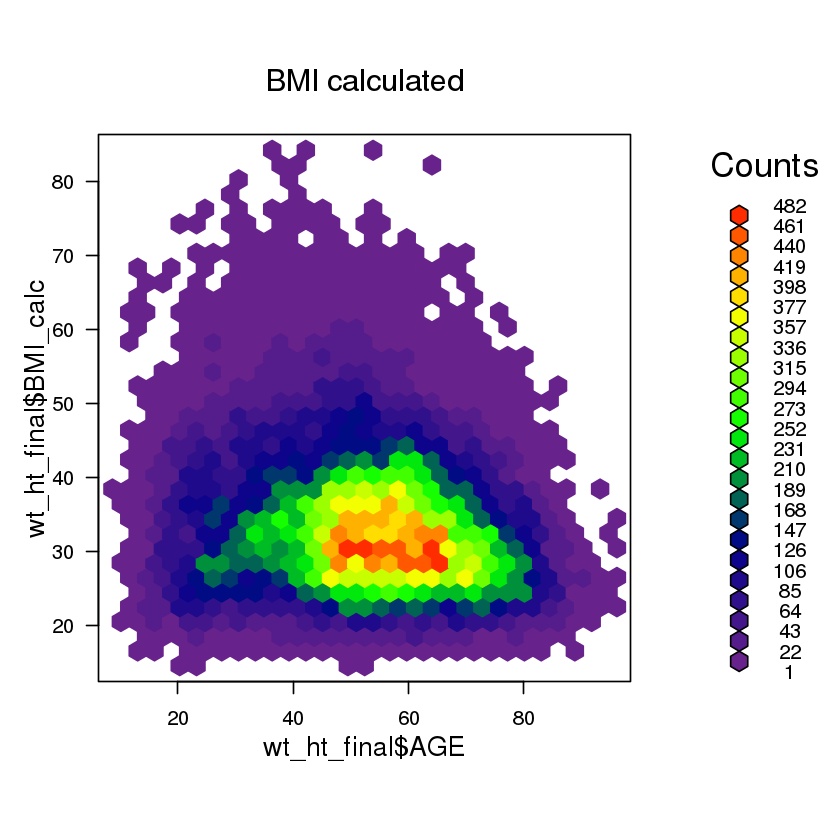

In [15]:
cols <- colorRampPalette(c("darkorchid4","darkblue","green","yellow", "red") )
hbin <- hexbin(wt_ht_final$AGE, wt_ht_final$BMI_calc)
#Purple color
plot(hbin, main="BMI calculated", colorcut = seq(0,1,length.out=24),
     colramp = function(n) cols(24) ) # , legend = 0 )


== End of Ex 3.3 ==